# Analysis for the experiments on the SINC scenario

In [14]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from itertools import combinations

In [15]:
# Settings
fileName = "resultsSINC.csv"
orderingStrategyPMedici = "IN_ORDER_SIZE_DESC"

In [16]:
# Load the file into a pandas dataframe
df = pd.read_csv(fileName, names=['Generator','ModelName','PercentageOfOldTsKept','TSSize','TSTime','Strength','Ordering',''], header=0, index_col=False)
# Set Ordering to empty string where it is NaN
df['Ordering'].fillna('', inplace=True)

## Group all executions

In [17]:
# Group data in df by Generator, ModelName, PercentageOfOldTsKept, Strength, and Ordering. For the TSSize and TS time, take the mean
df = df.groupby(['Generator','ModelName','PercentageOfOldTsKept','Strength','Ordering']).agg({'TSSize':'mean', 'TSTime':'mean'}).reset_index()
# Remove from df all the lines where generator is pMEDICI or pMEDICI+ but Ordering is not equal to orderingStrategyPMedici
dfFiltered = df[~(df['Generator'].str.contains('pMEDICI')) | (df['Generator'].str.contains('pMEDICI') & (df['Ordering'] == orderingStrategyPMedici))]
# Remove rows with strength 2
dfFiltered = dfFiltered[dfFiltered['Strength'] != 2]

In [18]:
# Count and print the number of timeouts per Generator
print(dfFiltered[dfFiltered['TSTime'] == -1].groupby(['Generator']).agg({'TSTime':'count'}))

              TSTime
Generator           
ACTS               7
ACTS w SEEDS       7
PICT               6
PICT w SEEDS      10
pMEDICI            8
pMEDICI+           8


In [19]:
# Set all timeouts (TSTime = -1) to TSTime = 300001 and with Size = MAX Size
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSSize'] = 100000
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSTime'] = 301000

In [29]:
# Print the average time and size for each Generator
# print(dfFiltered.groupby(['Generator']).agg({'TSSize':'mean', 'TSTime':'mean'}))
print(dfFiltered.groupby(['Generator']).agg({'TSTime':'mean'}))
print(dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])].groupby(['Generator']).agg({'TSSize':'mean'}))

                 TSTime
Generator              
ACTS          47093.216
ACTS w SEEDS  47091.764
PICT          37000.132
PICT w SEEDS  60989.148
pMEDICI       61978.924
pMEDICI+      58385.156
                   TSSize
Generator                
ACTS           864.473684
ACTS w SEEDS   864.473684
PICT            82.473684
PICT w SEEDS    77.489474
pMEDICI       1117.684211
pMEDICI+      1102.994737


## Time analysis

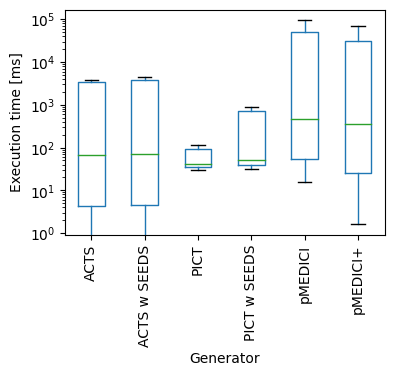

In [21]:
# Extract the execution time of different generators
dfExecutionTime = dfFiltered[['Generator','TSTime']]

# Boxplot the execution time of different generators and remove the outliers
ax = dfExecutionTime.boxplot(by='Generator', showfliers=False, grid=False, rot=90)
ax.set_yscale('log')
ax.set_ylabel('Execution time [ms]')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(4, 3)
# Export the figure in PDF
plt.savefig("pictures/SINC_TS_Time.pdf", bbox_inches='tight')

In [22]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfExecutionTime['Generator'].unique()
for generator1, generator2 in combinations(generators, 2):
    print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfExecutionTime[dfExecutionTime['Generator'] == generator1]['TSTime'], dfExecutionTime[dfExecutionTime['Generator'] == generator2]['TSTime']))

ACTS VS ACTS w SEEDS:
 WilcoxonResult(statistic=111.5, pvalue=0.004345025484754507)
ACTS VS PICT:
 WilcoxonResult(statistic=365.0, pvalue=0.12923511881504018)
ACTS VS PICT w SEEDS:
 WilcoxonResult(statistic=384.0, pvalue=0.28252215647494205)
ACTS VS pMEDICI:
 WilcoxonResult(statistic=280.0, pvalue=0.012104215953983533)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=304.0, pvalue=0.025812191225012344)
ACTS w SEEDS VS PICT:
 WilcoxonResult(statistic=360.0, pvalue=0.11514352150123057)
ACTS w SEEDS VS PICT w SEEDS:
 WilcoxonResult(statistic=428.0, pvalue=0.5868731085604295)
ACTS w SEEDS VS pMEDICI:
 WilcoxonResult(statistic=281.0, pvalue=0.012510026205973464)
ACTS w SEEDS VS pMEDICI+:
 WilcoxonResult(statistic=308.0, pvalue=0.02908548066460407)
PICT VS PICT w SEEDS:
 WilcoxonResult(statistic=188.5, pvalue=0.0003472698376027488)
PICT VS pMEDICI:
 WilcoxonResult(statistic=121.5, pvalue=1.307231190184465e-05)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=227.0, pvalue=0.0017623289466845572)
PICT w

c:\Users\Andrea_PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Size analysis

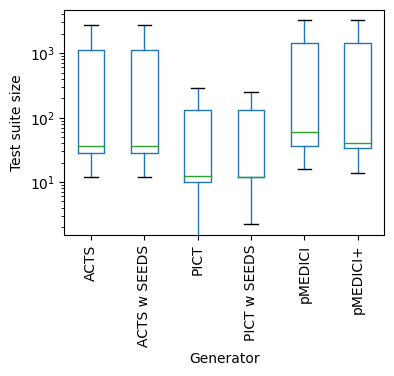

In [32]:
# Extract the TS Size of different generators
dfTSSize = dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])][['Generator','TSSize']]

# Boxplot the TS Size of different generators and remove the outliers
ax = dfTSSize.boxplot(by='Generator', showfliers=False, grid=False, rot=90)
ax.set_yscale('log')
ax.set_ylabel('Test suite size')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(4, 3)
# Export the figure in PDF
plt.savefig("pictures/SINC_TS_Size.pdf", bbox_inches='tight')

In [31]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfTSSize['Generator'].unique()
for generator1, generator2 in combinations(generators, 2):
    if not (generator1 in ['ACTS', 'ACTS W SEEDS'] and generator2 in ['ACTS', 'ACTS W SEEDS']):
        print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfTSSize[dfTSSize['Generator'] == generator1]['TSSize'], dfTSSize[dfTSSize['Generator'] == generator2]['TSSize'], zero_method='zsplit'))

ACTS VS ACTS w SEEDS:
 WilcoxonResult(statistic=370.5, pvalue=1.0)
ACTS VS PICT:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
ACTS VS PICT w SEEDS:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
ACTS VS pMEDICI:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
ACTS w SEEDS VS PICT:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
ACTS w SEEDS VS PICT w SEEDS:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
ACTS w SEEDS VS pMEDICI:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
ACTS w SEEDS VS pMEDICI+:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
PICT VS PICT w SEEDS:
 WilcoxonResult(statistic=323.0, pvalue=0.489257689337926)
PICT VS pMEDICI:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=0.0, pvalue=7.275957614183426e-12)
PICT w SEEDS VS pMEDICI:
 Wilcoxo

c:\Users\Andrea_PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
